### Preprocessing single cell expression data

Dataset: embryoid body single cell RNA seq over developmental time (https://data.mendeley.com/datasets/v6n743h5ng/)

In [12]:
import os
import scprep
import tasklogger
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle

In [3]:
data_path = '/Users/anuraglimdi/Desktop/Single_cell_workshop/Datasets/embryoid/'

In [14]:
sns.set_theme()
sns.set_style('ticks')

### Loading the data

Using the scprep to handle inputs.

In [7]:
# loading data as a dense dataframe
#using tasklogger to track how long it takes to load the data
with tasklogger.log_task("dense"):
    data_t1 = scprep.io.load_10X(os.path.join(data_path, "scRNAseq", "T0_1A"),
                                    sparse=False, gene_labels='both')

# measure the size of the matrix with pickle
print("Size: {:.1f}MB".format(len(pickle.dumps(data_t1)) / 1024**2))

Calculating dense...
Calculated dense in 8.23 seconds.
Size: 1196.1MB


In [8]:
# loading data as a sparse dataframe
#using tasklogger to track how long it takes to load the data
with tasklogger.log_task("sparse"):
    data_t1 = scprep.io.load_10X(os.path.join(data_path, "scRNAseq", "T0_1A"),
                                    sparse=True, gene_labels='both')

# measure the size of the matrix with pickle
print("Size: {:.1f}MB".format(len(pickle.dumps(data_t1)) / 1024**2))

Calculating sparse...
Calculated sparse in 7.60 seconds.
Size: 115.6MB


Turns out that the data is very sparse; most genes have zero transcripts in most cells, so a sparse representation turns out to be more efficient.

In [11]:
# loading the full dataset
sparse=True
data_time1 = scprep.io.load_10X(os.path.join(data_path, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels='both')
data_time2 = scprep.io.load_10X(os.path.join(data_path, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels='both')
data_time3 = scprep.io.load_10X(os.path.join(data_path, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels='both')
data_time4 = scprep.io.load_10X(os.path.join(data_path, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels='both')
data_time5 = scprep.io.load_10X(os.path.join(data_path, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels='both')

In [16]:
np.shape(np.sum(data_time1,axis=1))

(4649,)

### Library size

Due to the random nature of loading droplet with cells, not all of them will have exactly one cell (in fact this should follow a Poisson distribution). We therefore need to exclude droplets that we think correspond to doublets and empty cells.

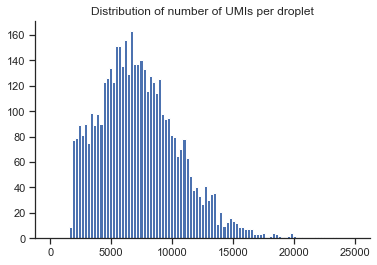

In [18]:
##library size for the first timepoint
plt.hist(np.sum(data_time1,axis=1), bins=np.linspace(0,25000,100))
plt.title('Distribution of number of UMIs per droplet')
sns.despine()

While some variation is expected (in terms of number of transcripts per cell), it is likely that the right tail of this distribution would correspond to doublets/triplets etc.

In [20]:
filtered_data = []
for batch in [data_time1, data_time2, data_time3, data_time4, data_time5]:
    percentiles = (15, 85)
    #using the scprep function instead of writing a new function by myself
    batch = scprep.filter.filter_library_size(batch, percentile=percentiles)
    filtered_data.append(batch)

In [21]:
del data_time1, data_time2, data_time3, data_time4, data_time5 # remove originally loaded data

In [22]:
data, sample_labels = scprep.utils.combine_batches(
    filtered_data, 
    ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"]
)

del filtered_data # remove from memory


### Removing dead cells

In the sample processsing protocols, some cells may start dying, and we probably want to exclude these from our analysis. Luckily high expression of mitochondrial genes can serve as a marker for cell death due to apoptosis.

Goal would be to identify cells with unusually high mitochondrial gene expression and remove them from analysis.

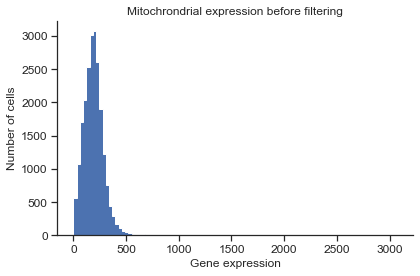

In [25]:
scprep.plot.plot_gene_set_expression(data, starts_with="MT-",
                                     library_size_normalize=True,
                                     title="Mitochrondrial expression before filtering")
sns.despine()

In [26]:
cutoff = 450

data_filt, sample_labels = scprep.filter.filter_gene_set_expression(
    data, sample_labels, starts_with="MT-",
    cutoff=cutoff, keep_cells='below', library_size_normalize=True)
data_filt.shape

(21460, 33694)

### Low expression genes

Many genes are expressed in very few cells or not expressed in any cells at all; because there's so little information about them, it's difficult to make any statements based on those data. Makes sense again to exclude them

In [30]:
cells_where_expressed = np.sum(data_filt>0, axis=0)   #summing along rows; how many cells is the gene expressed in?

Text(0, 0.5, 'How many genes')

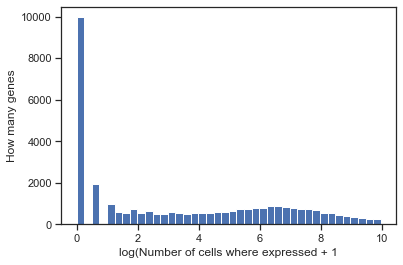

In [33]:
plt.hist(np.log(cells_where_expressed+1), bins=40)
plt.xlabel('log(Number of cells where expressed + 1')
plt.ylabel('How many genes')

In [34]:
cutoff = 5
data_filt = scprep.filter.filter_rare_genes(data_filt, min_cells=cutoff)

In [36]:
data_filt.shape

(21460, 19655)

Over 10,000 genes have been excluded from analysis because they're barely present in the dataset

### Normalization

The library size (# UMIs/cell) can be quite variable, and comparison of counts across cells is not possible. So, we will have to normalize the number of UMIs/cell to a fixed number

In [37]:
data_norm, library_size = scprep.normalize.library_size_normalize(data_filt, return_library_size=True)

In [38]:
#metadata containing info on library size and sample info (which timepoint)
metadata = pd.concat([library_size, sample_labels], axis=1)
metadata.head(5)

,library_size,sample_labels
AAACATACCAGAGG-1_Day 00-03,10387.0,Day 00-03
AAACATTGAAAGCA-1_Day 00-03,5738.0,Day 00-03
AAACATTGAAGTGA-1_Day 00-03,10007.0,Day 00-03
AAACATTGGAGGTG-1_Day 00-03,10231.0,Day 00-03
AAACATTGGTTTCT-1_Day 00-03,10389.0,Day 00-03


### Keeping most variable genes

A lot of genes are housekeeping genes (involved in essential physiological processes that don't differ across cell types), and so their expression levels are likely the same. To make the amount of data we're working with more manageable, we can also restrict our analysis to genes that are most variable across the cells in the experiment.

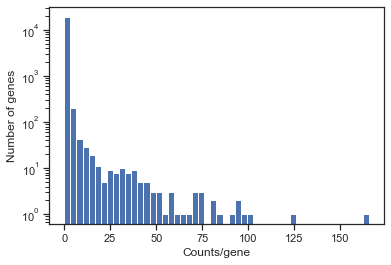

In [40]:
plt.hist(np.mean(data_norm, axis=0), bins=50)
plt.xlabel('Counts/gene')
plt.ylabel('Number of genes')
plt.yscale('log')

Text(0.5, 1.0, 'log(x+1) transformed data')

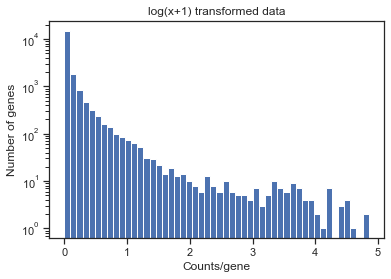

In [41]:
#to avoid the distribution being so long-tailed, we can transform the data
#option 1: log(counts+1)
plt.hist(np.mean(np.log(data_norm+1), axis=0), bins=50)
plt.xlabel('Counts/gene')
plt.ylabel('Number of genes')
plt.yscale('log')
plt.title('log(x+1) transformed data')

Text(0.5, 1.0, 'sqrt(x) transformed data')

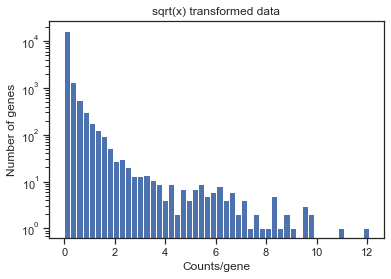

In [42]:
#option 2: square root
plt.hist(np.mean(np.sqrt(data_norm), axis=0), bins=50)
plt.xlabel('Counts/gene')
plt.ylabel('Number of genes')
plt.yscale('log')
plt.title('sqrt(x) transformed data')

<AxesSubplot:xlabel='Gene mean', ylabel='Standardized variance'>

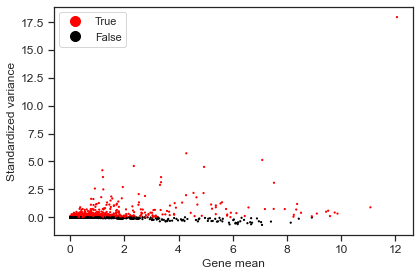

In [46]:
sqrt_data = np.sqrt(data_norm)
#plotting the variability in the expression levels vs mean
scprep.plot.plot_gene_variability(sqrt_data, percentile=90)
